<a href="https://colab.research.google.com/github/gdoorash/Prototypical-Networks-Implementation-/blob/master/Prototypical_Networks_Torchmeta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Torchmeta (learn-to-learn)

In [3]:
! pip install torchmeta

     |████████████████████████████████| 174kB 2.7MB/s 


In [0]:
import torchmeta
from torchmeta.modules import MetaBilinear, MetaModule, MetaBatchNorm2d, MetaSequential, MetaConv2d



import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import matplotlib.pyplot as plt 
from tqdm import tqdm




In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## An example from Torchmeta website 

In [0]:
# Create Dataset object for Omniglot and Dataloader...

from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader


# define the dataset and dataloader
om_dataset = omniglot("data", shots=5, ways=5, test_shots=15, meta_train=True, download=True)
om_dataloader = BatchMetaDataLoader(om_dataset, batch_size=16)



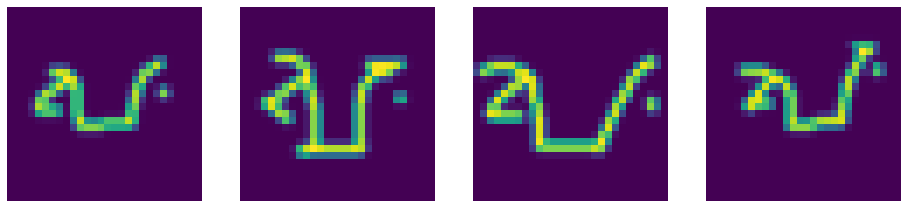

In [247]:
# Data insight ...
plt.figure(figsize=(16,6))
for image in range(4):
  plt.subplot(1, 4, image+1)
  plt.imshow(om_dataset.dataset[0][image][0].squeeze())
  plt.axis('off')
  
  

In [248]:
for batch in om_dataloader:
  t_input, t_target = batch["train"]
  print('Train input shape: {}'.format(train_inputs.shape))
  print('Train target shape: {}'.format(train_target.shape))

  t_inputs, t_target = batch["test"]
  print('Test input shape: {}'.format(test_inputs.shape))
  print('Test target shape: {}'.format(test_target.shape))
  

  break


Train input shape: torch.Size([16, 25, 1, 28, 28])
Train target shape: torch.Size([16, 25])
Test input shape: torch.Size([16, 75, 1, 28, 28])
Test target shape: torch.Size([16, 75])


### Prototypical Networks Architecture 
* with help of MAML example presented in the Torchmeta homepage. I use the same code with little changes.

In [0]:
# Build the scheme of the Prototypical Networks convolution blocks ...
def convblock(in_channels, out_channels):
  return MetaSequential(
      MetaConv2d(in_channels, out_channels, kernel_size=3, padding=1),
      MetaBatchNorm2d(out_channels),
      nn.ReLU(),
      nn.MaxPool2d(2)
  )

# Build the architecture of the embedding mirrors .....
class ConvolutionNNEmbedding(MetaModule):
  def __init__(self, in_channels, out_channels, hidden_size=64):
    super(ConvolutionNNEmbedding, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.hidden_size = hidden_size

    self.encoder = MetaSequential(
        convblock(in_channels, hidden_size),
        convblock(hidden_size, hidden_size),
        convblock(hidden_size, hidden_size),
        convblock(hidden_size, out_channels)
      )
    

  
  def forward (self, inputs):
        embeddings = self.encoder(inputs.view(-1, *inputs.shape[2:]))
        return embeddings.view(*inputs.shape[:2], -1)

In [0]:
def conv3x3(in_channels, out_channels, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, **kwargs),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

class PrototypicalNetwork(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_size=64):
        super(PrototypicalNetwork, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_size = hidden_size

        self.encoder = nn.Sequential(
            conv3x3(in_channels, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, hidden_size),
            conv3x3(hidden_size, out_channels)
        )

    def forward(self, inputs):

        embeddings = self.encoder(inputs.view(-1, *inputs.shape[2:]))
        return embeddings.view(*inputs.shape[:2], -1)

In [251]:
x = torch.randn((32, 25,1,28,28))
x.shape


torch.Size([32, 25, 1, 28, 28])

In [252]:
model = PrototypicalNetwork(1, 64)
x_embedding = model(x)
x_embedding.shape

torch.Size([32, 25, 64])

In [0]:
def get_num_samples(targets, num_classes, dtype=None):
    batch_size = targets.size(0)
    with torch.no_grad():
        ones = torch.ones_like(targets, dtype=dtype)
        num_samples = ones.new_zeros((batch_size, num_classes))
        num_samples.scatter_add_(1, targets, ones)
    return num_samples


# This function to get the prototypes of each class
def get_prototypes(embeddings, targets, num_classes):
    batch_size, embedding_size = embeddings.size(0), embeddings.size(-1)
    
    num_samples = get_num_samples(targets, num_classes, dtype=embeddings.dtype)
    num_samples.unsqueeze_(-1)
    num_samples = torch.max(num_samples, torch.ones_like(num_samples))

    prototypes = embeddings.new_zeros((batch_size, num_classes, embedding_size))
    indices = targets.unsqueeze(-1).expand_as(embeddings)
    prototypes.scatter_add_(1, indices, embeddings).div_(num_samples)

    return prototypes


# Compute the prototypical loss using Euclidean distance ...

def prototypical_loss(prototypes, embeddings, targets, **kwargs):
    squared_distances = torch.sum((prototypes.unsqueeze(2)
        - embeddings.unsqueeze(1)) ** 2, dim=-1)
    return F.cross_entropy(-squared_distances, targets, **kwargs)


# Compute the mean acuuracy on query points...
def get_accuracy(prototypes, embeddings, targets):
  
    sq_distances = torch.sum((prototypes.unsqueeze(1)
        - embeddings.unsqueeze(2)) ** 2, dim=-1)
    _, predictions = torch.min(sq_distances, dim=-1)
    return torch.mean(predictions.eq(targets).float())


## Training 

In [0]:
def train (model, dataloader, in_channels, out_channels, optimizer):

  model.to(device)
  model.train()
  
  for batch_idx, batch in enumerate(dataloader):
    model.zero_grad()

    train_inputs, train_targets = batch['train']
    train_inputs = train_inputs.to(device)
    train_targets = train_target.to(device)
    train_embeddings = model(train_inputs)

    test_inputs,  test_target = batch['test']
    test_inputs = test_inputs.to(device)
    test_targets = test_target.to(device)
    test_embeddings = model(test_inputs)


    prototypes = get_prototypes(train_embeddings, train_targets, dataloader.dataset.num_classes_per_task)
    loss = prototypical_loss(prototypes, test_embeddings, test_targets)

    loss.backward()
    optimizer.step()

    with torch.no_grad():
            accuracy = get_accuracy(prototypes, test_embeddings, test_targets)
            print('Accuracy={0:.4f}'.format(accuracy.item()))
    
    if batch_idx >= 100:
        break








In [0]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
in_channels = 1
out_channels = 64
# om_dataloader.b

In [256]:
train(model, om_dataloader, in_channels, out_channels, optimizer)

Accuracy=0.2367
Accuracy=0.1792
Accuracy=0.2575
Accuracy=0.1950
Accuracy=0.2308
Accuracy=0.1767
Accuracy=0.2533
Accuracy=0.2633
Accuracy=0.1900
Accuracy=0.2050
Accuracy=0.1800
Accuracy=0.2142
Accuracy=0.1783
Accuracy=0.1858
Accuracy=0.2233
Accuracy=0.2383
Accuracy=0.1975
Accuracy=0.2292
Accuracy=0.1358
Accuracy=0.2492
Accuracy=0.2158
Accuracy=0.1858
Accuracy=0.1992
Accuracy=0.2658
Accuracy=0.1667
Accuracy=0.2067
Accuracy=0.1825
Accuracy=0.2325
Accuracy=0.1300
Accuracy=0.2775
Accuracy=0.1792
Accuracy=0.2408
Accuracy=0.1983
Accuracy=0.1917
Accuracy=0.1725
Accuracy=0.2425
Accuracy=0.2017
Accuracy=0.1692
Accuracy=0.1558
Accuracy=0.1933
Accuracy=0.1942
Accuracy=0.2008
Accuracy=0.1867
Accuracy=0.2000
Accuracy=0.1608
Accuracy=0.1900
Accuracy=0.1625
Accuracy=0.1750
Accuracy=0.2000
Accuracy=0.1883
Accuracy=0.1958
Accuracy=0.1367
Accuracy=0.1883
Accuracy=0.2167
Accuracy=0.1900
Accuracy=0.1717
Accuracy=0.1967
Accuracy=0.1850
Accuracy=0.1425
Accuracy=0.1508
Accuracy=0.1717
Accuracy=0.2392
Accuracy